In [1]:
import numpy as np
import p2pspatial
import pulse2percept as p2p

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2017-11-14 18:58:31,659 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
argus = p2p.implants.ArgusII(eye='RE')

In [3]:
sim = p2pspatial.SpatialSimulation(argus)

In [4]:
sim.set_optic_fiber_layer(sampling=200)

In [5]:
sim.set_ganglion_cell_layer()

In [6]:
sim.calc_currents(['A3', 'E10'])

Calculating effective current for electrodes: ['A3' 'E10']
Done.


In [7]:
sim.gcl = {}

(<matplotlib.figure.Figure at 0x7f59dc340ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5972d85320>)

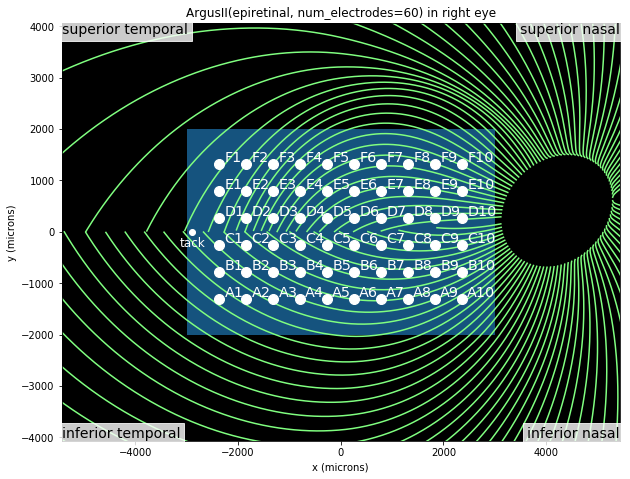

In [8]:
sim.plot_fundus()

In [77]:
from scipy import stats
def displace(r, eye='RE'):
    if eye == 'RE':
        # Right eyes: x < 0 is 'temporal'
        meridian = np.where(r < 0, 'temporal', 'nasal')
    else:
        # Left eyes: x < 0 is 'nasal'
        meridian = np.where(r < 0, 'nasal', 'temporal')
    
    alpha = np.where(meridian == 'temporal', 1.8938, 2.4607)
    beta = np.where(meridian == 'temporal', 2.4598, 1.7463)
    gamma = np.where(meridian == 'temporal', 0.91565, 0.77754)
    delta = np.where(meridian == 'temporal', 14.904, 15.111)
    mu = np.where(meridian == 'temporal', -0.09386, -0.15933)
    scale = np.where(meridian == 'temporal', 12.0, 10.0)
    
    rmubeta = (np.abs(r) - mu) / beta
    numer = delta * gamma * np.exp(-rmubeta ** gamma) * rmubeta ** (alpha * gamma - 1)
    denom = beta * stats.gamma.pdf(alpha, 5)

    return np.sign(r) * numer / denom / scale

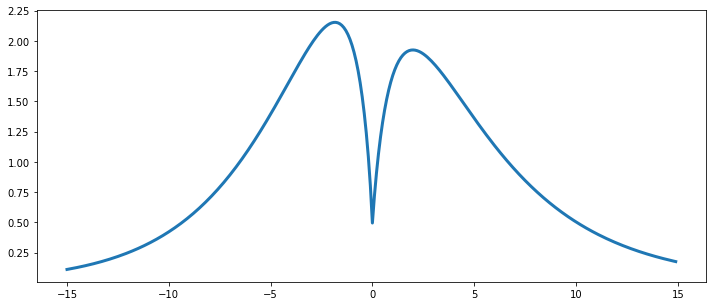

In [78]:
x = np.arange(-15, 15, 0.1)
plt.figure(figsize=(12, 5))
plt.plot(x, np.abs(displace(x, eye='RE')), linewidth=3)

In [79]:
import scipy.interpolate as spi
vf = np.arange(-15, 15, 0.1)
rs = vf + displace(vf, eye='RE')

# From visual field to retinal surface: This is what the
# Watson displacement curve does
vf2rs = spi.interp1d(vf, rs)

# From retinal surface to visual field: inverse of Watson
# This is what an implant might do
rs2vf = spi.interp1d(rs, vf)

In [80]:
from scipy import stats
def displace(r, meridian='temporal'):
    if meridian == 'temporal':
        alpha = 1.8938
        beta = 2.4598
        gamma = 0.91565
        delta = 14.904
        mu = -0.09386
        scale = 12.0
    else:
        alpha = 2.4607
        beta = 1.7463
        gamma = 0.77754
        delta = 15.111
        mu = -0.15933
        scale = 10.0
    
    rmubeta = (r - mu) / beta
    numer = delta * gamma * np.exp(-rmubeta ** gamma) * rmubeta ** (alpha * gamma - 1)
    denom = beta * stats.gamma.pdf(alpha, 5)
    

    return numer / denom / scale

In [81]:
import scipy.interpolate as spi
vf = np.arange(0, 15, 0.1)
rs = vf + displace(vf, 'temporal')

# from visual field to retinal surface
# what the Watson displacement curve does
rs_vf = spi.interp1d(vf, rs, fill_value='extrapolate')

# from retinal surface to visual field
# inverse of Watson displacement curve
# what an implant might do
vf_rs = spi.interp1d(rs, vf, fill_value='extrapolate')

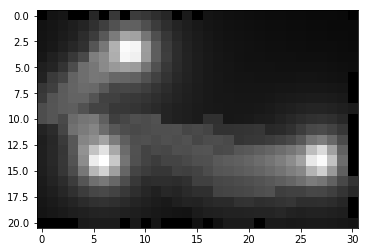

In [82]:
ecs = sim.pulse2percept('A3_E2_E10')
plt.imshow(ecs, cmap='gray')

In [30]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

In [31]:
def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

In [99]:
def warp_img(xy, xy_center, r_sampling=100.0):
    theta, rho_old = cart2pol((xy[:, 0] - xy_center[0]) * r_sampling,
                              (xy[:, 1] - xy_center[1]) * r_sampling)
    rho_old = p2p.retina.ret2dva(rho_old)
    
    # TODO: temporal vs nasal
    rho_new = vf_rs(rho_old)
    rho_new[rho_new < 0] = np.inf
    rho_new = p2p.retina.dva2ret(rho_new)

    # Back to Cartesian
    x_new, y_new = pol2cart(theta, rho_new)
    
    # Back to image coordinates
    x_new /= r_sampling
    y_new /= r_sampling

    return np.hstack((x_new + xy_center[0], y_new + xy_center[1]))

In [100]:
def plot_warped(img, deltax, xy_center=None):
    if not xy_center:
        xy_center = [img.shape[1] / 2.0, img.shape[0] / 2.0]
    warped = skit.warp(img, inverse_map=warp_img, map_args={'xy_center': xy_center, 'r_sampling': deltax})
    
    plt.figure(figsize=(14, 8))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.grid('off')
    plt.subplot(122)
    plt.imshow(warped, cmap='gray')
    plt.grid('off')

6.140350877192982


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.3-py3.5.egg/pulse2percept/retina.py:995: RuntimeWarning: invalid value encountered in subtract
  r_mm = 0.268 * r_deg + 3.427e-4 * r_deg ** 2 - 8.3309e-6 * r_deg ** 3


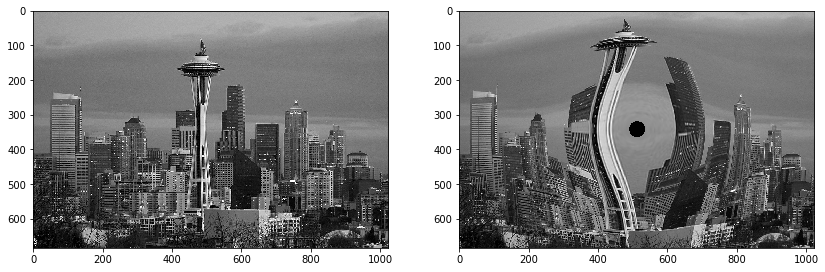

In [103]:
img = skio.imread('seattle.jpg', as_grey=True)
deltax = sim.ofl.sampling / img.shape[0] * ecs.shape[0]
print(deltax)
plot_warped(img, deltax)

In [87]:
def inverse_map(xy, xy_center, r_sampling=100.0):
    """Inverse map
    
    A function that transforms a ``(M, 2)`` array of ``(col, row)`` coordinates
    in the output image to their corresponding coordinates in the input image.
    
    This means we want to go from visual field coordinates (in the output)
    to retinal surface coordinates (in the input)
    """
    theta, rho_old = cart2pol((xy[:, 0] - xy_center[0]) * r_sampling,
                              (xy[:, 1] - xy_center[1]) * r_sampling)
    rho_old = p2p.retina.ret2dva(rho_old)
    
    # TODO: temporal vs nasal
    rho_new = vf_rs(rho_old)
    rho_new[rho_new < 0] = np.inf
    rho_new = p2p.retina.dva2ret(rho_new)

    # Back to Cartesian
    x_new, y_new = pol2cart(theta, rho_new)
    
    # Back to image coordinates
    x_new /= r_sampling
    y_new /= r_sampling

    return np.hstack((x_new + xy_center[0], y_new + xy_center[1]))

In [88]:
import skimage.transform as skit
import skimage.io as skio

In [89]:
img = skio.imread('seattle.jpg', as_grey=True)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.3-py3.5.egg/pulse2percept/retina.py:995: RuntimeWarning: invalid value encountered in subtract
  r_mm = 0.268 * r_deg + 3.427e-4 * r_deg ** 2 - 8.3309e-6 * r_deg ** 3


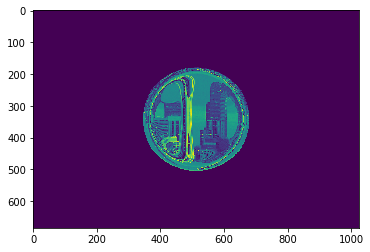

In [90]:
plt.imshow(skit.warp(img, inverse_map,
                     map_args={'xy_center': [img.shape[1] / 2.0, img.shape[0] / 2.0],
                               'r_sampling': sim.ofl.sampling}))